For this homework, make sure that you format your notbook nicely and cite all sources in the appropriate sections. Programmatically generate or embed any figures or graphs that you need.

Names: Calvin Zikakis, Sarah Schwallier

Section 1: Word2Vec paper questions
---------------------------

    1) Describe how a CBOW word embedding is generated.

    2) What is a CBOW word embedding and how is it different than a skip-gram word embedding?

    3) What is the task that the authors use to evaluate the generated word embeddings?

    4) What are PCA and t-SNE? Why are these important to the task of training and interpreting word embeddings?

Sources Cited
--------------------------
Efficient Estimation of Word Representations in Vector Space by Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean: https://arxiv.org/pdf/1301.3781.pdf  
J. Schler, M. Koppel, S. Argamon and J. Pennebaker (2006). Effects of Age and Gender on Blogging in Proceedings of 2006 AAAI Spring Symposium on Computational Approaches for Analyzing Weblogs.
SENTENCE ORDERING USING RECURRENT NEURAL NETWORKS by Lajanugen Logeswaran, Honglak Lee & Dragomir Radev
Speech and Language Processing
An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin

Section 2: Training your own word embeddings
--------------------------------

The spooky authors dataset consists of excerpts from authors of horror novels including Edgar Allan Poe, Mary Shelley, and HP Lovecraft. These excerpts each have a unique ID as well as a three letter tag describing which author wrote the excerpt. The data is split into a training set and a test set. The test set is lacking the three letter code which labels the author. 


We are using the The Blog Authorship Corpus for our secondary dataset. We decided on this dataset as it is comprised of 681,288 posts from 19,320 bloggers. We scanned through this database and pulled a small chunk of the total amount of posts. This was to reduce the overall size of the dataset to help with performance in training word embedding. This dataset will provide a data that is written with a style simular to normal human conversation simularly to the spooky authors dataset. This should help insure our generated sentences have a natural sound to them.





In [14]:
# import your libraries here
import numpy as np
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import keras


from keras.layers import Dense, Activation, Flatten
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.utils import to_categorical

from keras import backend as K
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf.Session(config=config)
K.set_session(session)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

import seaborn as sns
import csv


%matplotlib inline

In [15]:
# -----------------Secondary Dataset Formatting and Trimming-------------------
# This cell trims and fixes the secondary dataset to get the data in a workable style
import re
from csv import reader


def format_secondaryDataset(training_file_path, output_file, sentence_length):
    '''
    this function takes the dataset and splits it to sentences and stores those in a txt file

    training_file_path = filepath of blogposts.csv
    output_file = outputfile name (.txt)
    sentence_length = minimum length sentences to grab (value is how many words per sentences)
    '''

    
    with open(training_file_path, "r", encoding="utf-8") as file:
        sentences = file.readlines()
    #open file
    
    file.close()
    
    output = open(output_file, "w+")
    
    count = 0
    
    for line in reader(sentences):
        blog_post = line[6]
        #Line[6] contains the blog post
        
        if count >= 7:
        #skip the stuff in the beggining. It's unneeded
        
            sentences = blog_post.split(".")
            #split the post on the periods to extract individual sentences
            
            for sentence in sentences:
            #loop over our list of sentences
            
                if sentence != "":
                #some blog posts contain '...'. This creates empty sentences. We don't want empty sentences
                    
                    #lets clean the sentence of symbols and make it all lowercase
                    
                    res = re.sub(' +', ' ', sentence)
                    res.strip('\t')
                    res.strip('\n')
                    #strip tabs and newlines
                    
                    lower = res.lower()
                    #make all lower case

                    whitelist = set('abcdefghijklmnopqrstuvwxyz 1234567890')
                    no_numbers_punct = ''.join(filter(whitelist.__contains__, lower))
                    #gets rid of punctuation

                    cleaned = no_numbers_punct.split()
                    
                    black_list = ['urllink']
                    #allows us to remove all 'urlLink' occurances
                    
                    if len(cleaned) >= sentence_length:
                        #adjust 4 if you only want longer sentences
                        #we are only concerned with sentences longer than 4 words
                        output.write(" ".join([i for i in cleaned if i not in black_list]) + "\n")
                    
                    
        if count == 2000:
        #Do not need this full dataset... It's 800mb's
            break
        
        count += 1
        

format_secondaryDataset("blogtext.csv", "secondaryDataset.txt", 5)

In [16]:
# code to train your word embeddings
from csv import reader
from gensim.models import Word2Vec

EMB = 300


def convert_data(data):
#flattens data to 1D matrix
    data_flattened = []
    
    for sentences in data:
        for word in sentences:
            data_flattened.append(word)
    
    return data_flattened



def standardize_length(words,length):
    counter = 0
    output = []
    
    sentence = []
    for word in words:
        if counter < length:
            sentence.append(word)
        else:
            output.append(sentence)
            sentence = []
            counter = -1
        counter += 1
            
    return output

# -----------------Primary Dataset-------------------

def Clean_data_primary_dataset(training_file_path):
    #This function tokenizes the primary dataset and returns a cleaned version where each word making up a sentence is a nested list inside a larger list of the corpus
    output_list = []

    with open(training_file_path, "r", encoding="utf-8") as file:
        sentences = file.readlines()
    #open file
    file.close()
    
    count = 0
        
    for line in reader(sentences):
        
        if count != 0:
        #don't want first sentence

            sentence = line[1]
            
            lower = sentence.lower()
            #make all lower case

            whitelist = set('abcdefghijklmnopqrstuvwxyz 1234567890')
            no_numbers_punct = ''.join(filter(whitelist.__contains__, lower))
            #gets rid of punctuation

            cleaned = no_numbers_punct.split()
            
            output_list.append(cleaned)
            
        count += 1

    return output_list


pri_Dataset = convert_data(Clean_data_primary_dataset("train.csv"))
#imports and cleans dataset

sentences_primaryDataset = standardize_length(pri_Dataset, 4)

model_primaryDataset = Word2Vec(sentences_primaryDataset, min_count=1, size=EMB, window=4, negative=10, iter=10, workers=4)
#creates word2vec model

print(model_primaryDataset)
#model summary

words_primaryDataset = list(model_primaryDataset.wv.vocab)
print(words_primaryDataset)
#shows the vocab

print(model_primaryDataset['sentence'])
#our model

# -----------------Secondary Dataset-------------------

#secondary dataset is stored as 'secondaryDataset.txt' after processing it

def tokenize_secondary_dataset(training_file_path):
    #tokenizes the secondary dataset and returns a cleaned version where each word making up a sentence is a nested list inside a larger list of the corpus
    
    output_list = []

    with open(training_file_path) as file:
        sentences = file.readlines()
        
    #open file
    file.close()
    
    for sentence in sentences:
    #loop over sentences
    
        words = sentence.split()
        #split sentences on the words
        
        output_list.append(words)
        #append words list to final output
    
    return output_list


sec_Dataset = convert_data(tokenize_secondary_dataset("secondaryDataset.txt"))
#secondary sentences

sentences_secondaryDataset = standardize_length(sec_Dataset, 4)

model_secondaryDataset = Word2Vec(sentences_secondaryDataset, min_count=1, size=EMB, window=4, negative=10, iter=10, workers=4)
#creates word2vec model

print(model_secondaryDataset)
#model summary

words_secondaryDataset = list(model_secondaryDataset.wv.vocab)
print(words_secondaryDataset)
#shows the vocab

print(model_secondaryDataset['sentence'])
#our model


Word2Vec(vocab=23327, size=300, alpha=0.025)
['this', 'process', 'however', 'afforded', 'no', 'means', 'of', 'ascertaining', 'dimensions', 'my', 'dungeon', 'i', 'might', 'make', 'its', 'and', 'return', 'to', 'the', 'whence', 'set', 'out', 'being', 'aware', 'so', 'perfectly', 'uniform', 'seemed', 'wall', 'it', 'never', 'once', 'me', 'that', 'be', 'a', 'mere', 'in', 'his', 'left', 'hand', 'gold', 'snuff', 'box', 'which', 'as', 'he', 'capered', 'hill', 'cutting', 'all', 'fantastic', 'steps', 'incessantly', 'with', 'an', 'greatest', 'possible', 'satisfaction', 'how', 'lovely', 'is', 'we', 'looked', 'from', 'terrace', 'on', 'sixteen', 'counties', 'spread', 'beneath', 'speckled', 'happy', 'cottages', 'wealthier', 'years', 'heart', 'cheering', 'finding', 'nothing', 'else', 'not', 'superintendent', 'abandoned', 'attempts', 'but', 'perplexed', 'occasionally', 'steals', 'over', 'sits', 'thinking', 'desk', 'youth', 'solitude', 'best', 'spent', 'under', 'your', 'gentle', 'feminine', 'fosterage', '

C:\Users\Calvin\anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Word2Vec(vocab=22884, size=300, alpha=0.025)
['somehow', 'cocacola', 'has', 'a', 'of', 'summing', 'up', 'things', 'well', 'in', 'the', 'early', 'they', 'had', 'as', 'their', 'jingle', 'id', 'like', 'to', 'world', 'coke', 'tune', 'teach', 'sing', 'that', 'pretty', 'much', 'postwoodstock', 'era', 'it', 'didnt', 'add', 'sales', 'but', 'catchy', 'cokes', 'theme', 'is', 'stop', 'which', 'sums', 'lot', 'about', 'korea', 'koreans', 'look', 'at', 'how', 'couple', 'now', 'stopped', 'thinking', 'and', 'feeling', 'course', 'high', 'regard', 'for', 'math', 'logic', 'such', 'deep', 'down', 'think', 'many', 'really', 'work', 'on', 'emotion', 'than', 'anything', 'else', 'westerners', 'sublimate', 'this', 'moreso', 'least', 'display', 'different', 'way', 'are', 'probably', 'context', 'we', 'do', 'anyways', 'if', 'you', 'losing', 'repeat', 'yourself', 'feel', 'everything', 'be', 'alright', 'country', 'i', 'may', 'from', 'koreas', 'history', 'been', 'invaded', 'reported', 'times', 'over', 'years', 'each

C:\Users\Calvin\anaconda3\lib\site-packages\ipykernel_launcher.py:132: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Sources Cited
--------------------------
An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin


Brownlee, Jason. “How to Develop Word Embeddings in Python with Gensim.” Machine Learning Mastery, 7 Aug. 2019, machinelearningmastery.com/develop-word-embeddings-python-gensim/.

Section 3: Evaluate the differences between the word embeddings
----------------------------

(make sure to include graphs, figures, and paragraphs with full sentences)

C:\Users\Calvin\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Calvin\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


Word:  validity 

[('whims', 0.9916011095046997), ('brightness', 0.9907011389732361), ('african', 0.9905738830566406), ('reception', 0.9904791116714478), ('assurances', 0.990422248840332), ('unconsciousness', 0.9899426698684692), ('disk', 0.9898627996444702), ('roses', 0.9898220300674438), ('seriousness', 0.9897656440734863), ('officer', 0.9896256327629089)] 

[('charm', 0.9967656135559082), ('arrival', 0.9955854415893555), ('pint', 0.9949775338172913), ('folds', 0.99489426612854), ('jb', 0.9947607517242432), ('actions', 0.9943181276321411), ('hifi', 0.9941644668579102), ('artwork', 0.9941228628158569), ('recognition', 0.9940728545188904), ('presidential', 0.9940438270568848)] 

validity
validity


C:\Users\Calvin\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


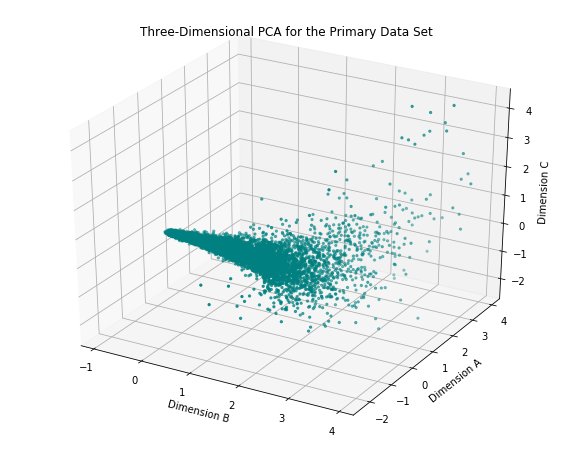

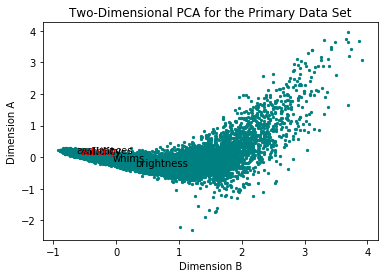

Word:  hugenot 

[('randolph', 0.9982109069824219), ('spokesman', 0.9981934428215027), ('surfaces', 0.9979104995727539), ('incessant', 0.9978603720664978), ('binoen', 0.9976721405982971), ('1920s', 0.9976121187210083), ('soap', 0.9975987672805786), ('yeppers', 0.9975858330726624), ('trustworthy', 0.9975266456604004), ('recommendations', 0.9974542856216431)] 

[('randolph', 0.9982109069824219), ('spokesman', 0.9981934428215027), ('surfaces', 0.9979104995727539), ('incessant', 0.9978603720664978), ('binoen', 0.9976721405982971), ('1920s', 0.9976121187210083), ('soap', 0.9975987672805786), ('yeppers', 0.9975858330726624), ('trustworthy', 0.9975266456604004), ('recommendations', 0.9974542856216431)] 

hugenot
hugenot


C:\Users\Calvin\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


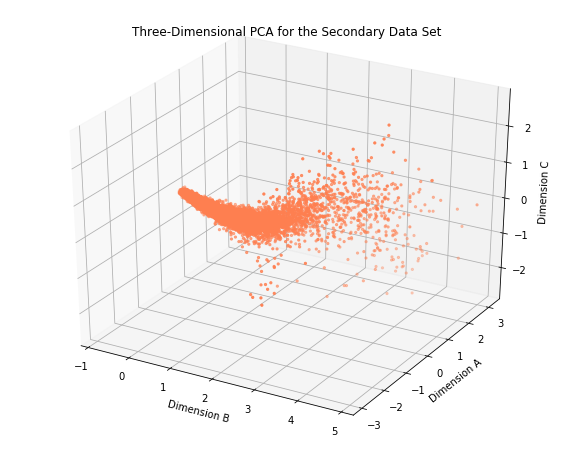

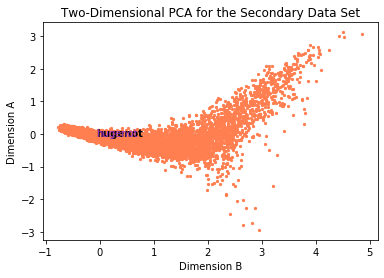

In [17]:
# -----------------Section 3: Evaluate the differences between the word embeddings-------------------
#This section is evaluating via PCAs
primaryModel = model_primaryDataset[model_primaryDataset.wv.vocab]
secondaryModel = model_secondaryDataset[model_secondaryDataset.wv.vocab]
#Retirives the vectors from each embedding

def buildSimilarWords(randWord, pSimilarWords, sSimilarWords):
    psList = []
    psList.append(randWord)
    for wordTuple in pSimilarWords:
        word  = wordTuple[0]
        if word not in words_secondaryDataset:
            psList.append(word)
    return psList

def getPrimaryIndex(word):
    for i, iWord in enumerate(list(model_primaryDataset.wv.vocab)):
        if word == iWord:
            return i

randIndex = np.random.randint(0, high=len(words_primaryDataset))
randWord = words_primaryDataset[randIndex]
while randWord not in words_secondaryDataset:
    randIndex = np.random.randint(0, high=len(words_primaryDataset))
    randWord = words_primaryDataset[randIndex]
pSimilarWords = model_primaryDataset.wv.most_similar(randWord)
sSimilarWords = model_secondaryDataset.wv.most_similar(randWord)
print("Word: ", randWord, "\n")
print(pSimilarWords, "\n")
print(sSimilarWords, "\n")
similarWords = buildSimilarWords(randWord, pSimilarWords, sSimilarWords)
dnpWord = model_primaryDataset.wv.doesnt_match(similarWords)
dnsWord = model_secondaryDataset.wv.doesnt_match(similarWords)
print(dnpWord)
print(dnsWord)

pcaP = PCA(n_components=3)
resultP = pcaP.fit_transform(primaryModel)
ax = plt.figure(figsize=(10,8)).gca(projection='3d')
ax.scatter(resultP[:, 0], resultP[:, 1], resultP[:, 2], s=5, color='teal')
words_primaryDataset = list(model_primaryDataset.wv.vocab)
ax.set_title('Three-Dimensional PCA for the Primary Data Set')
ax.set_xlabel('Dimension B')
ax.set_ylabel('Dimension A')
ax.set_zlabel('Dimension C')
#ax.text(resultP[randIndex, 0], resultP[randIndex, 1], resultP[randIndex, 2], randWord,  fontweight='bold')
#for word in similarWords:
#    if word != dnpWord and word != randWord:
#        p2 = getPrimaryIndex(word)
#        ax.text(resultP[p2, 0], resultP[p2, 1], resultP[p2, 2], word)
#p2 = words_primaryDataset.index(dnpWord)
#ax.text(resultP[p2, 0], resultP[p2, 1], resultP[p2, 2], dnpWord, color='red')
plt.show()
#PCA model for the primary dataset
pcaP = PCA(n_components=2)
resultP = pcaP.fit_transform(primaryModel)
plt.scatter(resultP[:, 0], resultP[:, 1], s=5, color='teal')
words_primaryDataset = list(model_primaryDataset.wv.vocab)
plt.title('Two-Dimensional PCA for the Primary Data Set')
plt.xlabel('Dimension B')
plt.ylabel('Dimension A')
plt.annotate(randWord, xy=(resultP[randIndex, 0], resultP[randIndex, 1]),  fontweight='bold')
for word in similarWords:
    if word != dnpWord and word != randWord:
        p2 = getPrimaryIndex(word)
        plt.annotate(word, xy=(resultP[p2, 0], resultP[p2, 1]))
p2 = words_primaryDataset.index(dnpWord)
plt.annotate(dnpWord, xy=(resultP[p2, 0], resultP[p2, 1]), color='red')
plt.show()
#PCA model for the primary dataset

randIndex = np.random.randint(0, high=len(words_secondaryDataset))
randWord = words_secondaryDataset[randIndex]
while randWord not in words_secondaryDataset:
    randIndex = np.random.randint(0, high=len(words_secondaryDataset))
    randWord = words_secondaryDataset[randIndex]
pSimilarWords = model_secondaryDataset.wv.most_similar(randWord)
sSimilarWords = model_secondaryDataset.wv.most_similar(randWord)
print("Word: ", randWord, "\n")
print(pSimilarWords, "\n")
print(sSimilarWords, "\n")
similarWords = buildSimilarWords(randWord, pSimilarWords, sSimilarWords)
dnpWord = model_secondaryDataset.wv.doesnt_match(similarWords)
dnsWord = model_secondaryDataset.wv.doesnt_match(similarWords)
print(dnpWord)
print(dnsWord)
def getSecondaryIndex(word):
    for i, iWord in enumerate(list(model_secondaryDataset.wv.vocab)):
        if word == iWord:
            return i
pcaS = PCA(n_components=3)
resultS = pcaS.fit_transform(secondaryModel)
ax = plt.figure(figsize=(10,8)).gca(projection='3d')
ax.scatter(resultS[:, 0], resultS[:, 1], resultS[:, 2], s=5, color='coral')
words_secondaryDataset = list(model_secondaryDataset.wv.vocab)
ax.set_title('Three-Dimensional PCA for the Secondary Data Set')
ax.set_xlabel('Dimension B')
ax.set_ylabel('Dimension A')
ax.set_zlabel('Dimension C')
#ax.text(resultS[randIndex, 0], resultS[randIndex, 1], resultS[randIndex, 2], randWord,  fontweight='bold')
#for word in similarWords:
#    if word != dnpWord and word != randWord:
#        s2 = getSecondaryIndex(word)
#        ax.text(resultS[s2, 0], resultS[s2, 1], resultS[s2, 2], word)
#s2 = words_secondaryDataset.index(dnpWord)
#ax.text(resultS[s2, 0], resultS[s2, 1], resultS[s2, 2], dnpWord, color='darkorchid')
plt.show()

def getSecondaryIndex(word):
    for i, iWord in enumerate(list(model_secondaryDataset.wv.vocab)):
        if word == iWord:
            return i

#PCA model for the secondary dataset
pcaS = PCA(n_components=2)
resultS = pcaS.fit_transform(secondaryModel)
plt.scatter(resultS[:, 0], resultS[:, 1], s=5, color='coral')
words_secondaryDataset = list(model_secondaryDataset.wv.vocab)
plt.title('Two-Dimensional PCA for the Secondary Data Set')
plt.xlabel('Dimension B')
plt.ylabel('Dimension A')
plt.annotate(randWord, xy=(resultS[randIndex, 0], resultS[randIndex, 1]),  fontweight='bold')
for word in similarWords:
    if word != dnpWord and word != randWord:
        s2 = getSecondaryIndex(word)
        plt.annotate(word, xy=(resultS[s2, 0], resultS[s2, 1]))
s2 = words_secondaryDataset.index(dnpWord)
plt.annotate(dnpWord, xy=(resultS[s2, 0], resultS[s2, 1]), color='darkorchid')
plt.show()
#PCA model for the secondary dataset

Sources Cited
--------------------------
An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin
Brownlee, Jason. “How to Develop Word Embeddings in Python with Gensim.” Machine Learning Mastery, 7 Aug. 2019, machinelearningmastery.com/develop-word-embeddings-python-gensim/. <br>
Durksen, Luuk. "Visualising high-dimensional datasets using PCA and t-SNE in Python" 29 Oct. 2016, https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

Section 4: Feedforward Neural Language Model
--------------------------

In [18]:
# code to train a feedforward neural language model
# on a set of given word embeddings
# make sure not to just copy + paste to train your two

vec = 300

def convert_data(data):
#flattens data to 1D matrix
    data_flattened = []
    
    for sentences in data:
        for word in sentences:
            data_flattened.append(word)
    
    return data_flattened


def data_to_index(data, model):
#assigns index values to data
    data_index = []
    
    for word in data:
        if word in model:
            data_index.append(model.vocab[word].index)
            
    return data_index


def generate_words(word2vec_model, keras_model, words_list, length=12):
    word_index = []
    words = []
    #for word in words_list:
        #word_index.append(word2vec_model.wv.vocab[word].index)
    index1 = word2vec_model.wv.vocab[words_list[0]].index
    index2 = word2vec_model.wv.vocab[words_list[1]].index
    index3 = word2vec_model.wv.vocab[words_list[2]].index
    word_data_x = np.concatenate((word2vec_model.wv.vectors[index1], word2vec_model.wv.vectors[index2], word2vec_model.wv.vectors[index3]))
    
    for i in range(length):
        pred = keras_model.predict(x=word_data_x)
        #pred.astype('float64')
        #probability = np.random.multinomial(1,pred,1)
        
        #prediction = np.argmax(probability[-1])
        #word_data_x.append(prediction)

        index_to_word = word2vec_model.wv.index2word[pred]
        words.append(index_to_word)
    return(words)
    



#------------------ Primary Dataset -----------------
#before we can train, break down the dataset into sections. this will result in nested arrays of length 100 where each nest contains 100 words. This will lower memory requirements
def section_data(sentences):
    section = []
    output = []
    
    i = 0
    
    for sentence in sentences:
        
        i += 1
        section.append(sentence) 
        
        if i % 100 == 0:
            output.append(section)
            section = []
        
    return output

sentences = section_data(sentences_primaryDataset)
print(np.asarray(sentences[0]).shape)

def train(sentences, model):
    sentence_length = 4
    
    x_train = []
    y_train = []
    
    for section in sentences:

        
        for sentence in section:
            
            index1 = model.wv.vocab[sentence[0]].index
            index2 = model.wv.vocab[sentence[1]].index
            index3 = model.wv.vocab[sentence[2]].index                
            index_label = model.wv.vocab[sentence[3]].index
            
            training_data_x = np.concatenate((model.wv.vectors[index1], model.wv.vectors[index2], model.wv.vectors[index3]))
            x_train.append(training_data_x)
            
            y_train.append(index_label)
                    
            
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)

    return x_train, y_train
    
        
        
print("-------------Formatting test data-------------")
x_train, y_train = train(sentences, model_primaryDataset)

y_labels = to_categorical(y_train, num_classes=len(model_primaryDataset.wv.vocab),dtype='int16')
   
        
#training_data_x, training_data_y = train(sentences_primaryDataset, model_primaryDataset)
print(x_train.shape, "x training shape")
print(y_labels.shape, "y training shape")
    
#Create Keras Model

print("-------------Building Model-------------")
primary_FFNN = Sequential()

primary_FFNN.add(Dense(units=3000, input_shape=(900,)))
primary_FFNN.add(Dense(units=len(model_primaryDataset.wv.vocab)))

primary_FFNN.compile(optimizer="adam", loss='mean_squared_error')

primary_FFNN.summary()

print("-------------Training Model-------------")

primary_FFNN.fit(x_train, y_labels, batch_size=16)


print("-------------Generating Words-------------")
#words = generate_words(model_primaryDataset, primary_FFNN, ["this", "is", "not"])        
print(words)




"""
#------------------ Secondary Dataset -----------------

  
trained_weights_secondaryDataset = model_secondaryDataset.wv.vectors
vocab_size_secondaryDataset, embedding_size_secondaryDataset = trained_weights_secondaryDataset.shape



secondary_FFNN = Sequential()
secondary_FFNN.add(Embedding(input_dim=vocab_size_secondaryDataset, output_dim=embedding_size_secondaryDataset, weights=[trained_weights_secondaryDataset]))
secondary_FFNN.add(Dense(units=vocab_size_secondaryDataset))
secondary_FFNN.add(Activation('softmax'))
secondary_FFNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy')


        
words = generate_words(model_secondaryDataset,secondary_FFNN, ["cocacola","is","cool"])        
print(words)

        
"""

(100, 4)
-------------Formatting test data-------------
(104500, 900) x training shape
(104500, 23327) y training shape
-------------Building Model-------------
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 3000)              2703000   
_________________________________________________________________
dense_18 (Dense)             (None, 23327)             70004327  
Total params: 72,707,327
Trainable params: 72,707,327
Non-trainable params: 0
_________________________________________________________________
-------------Training Model-------------


ResourceExhaustedError: OOM when allocating tensor of shape [900,3000] and type float
	 [[node training_7/Adam/v_0 (defined at C:\Users\Calvin\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:963) ]]

Original stack trace for 'training_7/Adam/v_0':
  File "C:\Users\Calvin\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Calvin\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Calvin\anaconda3\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\Calvin\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 583, in start
    self.io_loop.start()
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Calvin\anaconda3\lib\asyncio\base_events.py", line 538, in run_forever
    self._run_once()
  File "C:\Users\Calvin\anaconda3\lib\asyncio\base_events.py", line 1782, in _run_once
    handle._run()
  File "C:\Users\Calvin\anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 377, in dispatch_queue
    yield self.process_one()
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tornado\gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tornado\gen.py", line 714, in __init__
    self.run()
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\Calvin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-ba21f0354cd3>", line 129, in <module>
    primary_FFNN.fit(x_train, y_labels, batch_size=16)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\keras\engine\training.py", line 1213, in fit
    self._make_train_function()
  File "C:\Users\Calvin\anaconda3\lib\site-packages\keras\engine\training.py", line 316, in _make_train_function
    loss=self.total_loss)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\keras\optimizers.py", line 523, in get_updates
    for (i, p) in enumerate(params)]
  File "C:\Users\Calvin\anaconda3\lib\site-packages\keras\optimizers.py", line 523, in <listcomp>
    for (i, p) in enumerate(params)]
  File "C:\Users\Calvin\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 963, in zeros
    v = tf.zeros(shape=shape, dtype=dtype, name=name)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1883, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3613, in fill
    "Fill", dims=dims, value=value, name=name)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\Users\Calvin\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


Sources Cited
--------------------------
An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin

Section 5: Recurrent Neural Language Model
--------------------------

In [ ]:
# code to train a recurrent neural language model 
# on a set of given word embeddings
# make sure not to just copy + paste to train your two 

vec = 300

def convert_data(data):
#flattens data to 1D matrix
    data_flattened = []
    
    for sentences in data:
        for word in sentences:
            data_flattened.append(word)
    
    return data_flattened


def data_to_index(data, model):
#assigns index values to data
    data_index = []
    
    for word in data:
        if word in model:
            data_index.append(model.vocab[word].index)
            
    return data_index


def generate_words(word2vec_model, keras_model, word, length=12):
    word_index = [word2vec_model.wv.vocab[word].index]
    words = [word]
    
    for i in range(length):
        pred = keras_model.predict(x=np.array(word_index))
        pred.astype('float64')
        probability = np.random.multinomial(1,pred,1)
        
        prediction = np.argmax(probability)
        word_index.append(prediction)

        
        index_to_word = word2vec_model.wv.index2word[prediction]
        words.append(index_to_word)
    return(words)
        
#------------------ Primary Dataset -----------------


#Create Keras Model

trained_weights_primaryDataset = model_primaryDataset.wv.syn0
vocab_size_primaryDataset, embedding_size_primaryDataset = trained_weights_primaryDataset.shape



primary_RNN = Sequential()
primary_RNN.add(Embedding(input_dim=vocab_size_primaryDataset, output_dim=embedding_size_primaryDataset, weights=[trained_weights_primaryDataset]))
primary_RNN.add(Simple)
primary_RNN.add(Dense(units=vocab_size_primaryDataset))
primary_RNN.add(Activation('relu'))
primary_RNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy')


        
words = generate_words(model_primaryDataset,primary_FFNN, "this")        
print(words)


#------------------ Secondary Dataset -----------------

  
trained_weights_secondaryDataset = model_secondaryDataset.wv.syn0
vocab_size_secondaryDataset, embedding_size_secondaryDataset = trained_weights_secondaryDataset.shape



secondary_FFNN = Sequential()
secondary_FFNN.add(Embedding(input_dim=vocab_size_secondaryDataset, output_dim=embedding_size_secondaryDataset, weights=[trained_weights_secondaryDataset]))
secondary_FFNN.add(Dense(units=vocab_size_secondaryDataset))
secondary_FFNN.add(Dense(300))
secondary_FFNN.add(Activation('relu'))
secondary_FFNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy')


        
words = generate_words(model_secondaryDataset,secondary_FFNN, "cocacola")        
print(words)

        
        

Sources Cited
--------------------------
An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin

“Python Gensim Word2Vec Tutorial with TensorFlow and Keras.” Adventures in Machine Learning, 1 Sept. 2017, adventuresinmachinelearning.com/gensim-word2vec-tutorial/.


Shukla, Vishal ShuklaVishal. “Using Pre-Trained word2vec with LSTM for Word Generation.” Stack Overflow, 1AD, stackoverflow.com/questions/42064690/using-pre-trained-word2vec-with-lstm-for-word-generation.

Section 6: Evaluate the differences between the two language models
----------------------------

(make sure to include graphs, figures, and paragraphs with full sentences)

Sources Cited
--------------------------
An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition by Daniel Jurafsky and James H. Martin